# 第三节：Transformer 实战

本节将介绍 Transformer 在粒子物理分类任务中的实战应用。我们将从上一节搭建好的 Transformer 模块出发，利用 PyTorch 和 pytorch-lightning 环境部署到真实的粒子物理应用中。

**如果在 Google Colab 中使用，请首先运行下面的命令安装相关的python包。**

In [ ]:
! pip install uproot<5.0.0 weaver-core
! pip install pytorch_lightning

## 背景介绍

在大型强子对撞机（LHC）的高能物理的实验中，两束高能质子束构成一个个团簇流进行对撞，每个团簇发生的对撞称为一个**事例**。对撞会发生复杂的物理过程，产生新粒子——这由目前的量子场论理论可以解释。我们能够采集的信号的是这些产生的粒子与探测器相互作用后，获得的径迹信息、能量沉积信息等等。利用算法，我们可以把所有的末态粒子重建出来，进而知道它所对应的物理过程，转化为对撞机物理的一个重要的可观测量：一个物理过程的微分散射截面。通过比较实验测得的截面和理论预计的截面，我们可以精确测量一些量子场论的理论参数、寻找新粒子可能存在的迹象等等。

<img src="figures/HiggsEventDisplay.jpg" alt="Drawing" width=500/>

Higgs 玻色子的发现补全了标准模型最后一块拼图，是粒子物理实验的一个里程碑。接下来 LHC 实验的一个重要的物理目标，是研究希格斯的自相互作用。在标准模型中，电弱对称性破缺后，拉式量中会出现Higgs的自耦合项。对应到具体的物理过程，即出现三个或四个Higgs玻色子直接耦合的情形。画成费曼图的话，一个典型的过程就如下图所示。

<img src="figures/DihiggsFD.jpg" alt="Drawing" width=300/>

这个过程中，由于Higgs的自耦合，最终产生了两个Higgs玻色子。如果能够测量这个过程的物理散射截面，那么便可以对自耦合的修正因子$\kappa_\lambda$进行限制。我们这里讨论一种特殊的衰变模式，即一个Higgs衰变到分支比最大的$b\bar{b}$末态，另一个Higgs衰变到$W^+W^-$。在本例中，我们将通过重建的事例信息，分辨双希格斯物理中的物理信号 $HH\to b\bar{b}W^+W^-$ 与其最大的本底过程$t\bar{t}\to b\bar{b}W^+W^-$。˙信号和本底过程有如下的特点：
- 二者的末态粒子完全相同：两个b夸克会形成两个b喷注；两个W玻色子研究其轻子化衰变，生成两个轻子（即电子或μ子）和看不⻅的中微子；
- 但二者的末态粒子的相空间稍有差别: $HH$ 和 $t\bar{t}$ 各自是头对头出射的（因极端相对论效应），所以前者 $bb$ 和 $WW$ 可能各自很近，后者两个 $bW$ 对可能各自很近；
- 我们可以实验上测出信号和背景的末态信息，即两个 b 喷注 + 两个轻子的信息（四动量、喷注性质的变量等等）。

那么，能否用神经网络技术，利用重建的事例信息区分两种过程？

<img src="figures/SigBkgFS.png" alt="Drawing" width=700/>

> 对于事例重建信息的说明：
>
> - 首先，在LHC上夸克（如底夸克）和胶子会最终形成喷注——它们是聚焦在一定半径的锥角内的一束能量很强的强子簇设。强相互作用在能标较高的情况下较弱，但在低能标下表现地非常强，夸克因紧闭效应无法单独存在，需与其它夸克紧密结合，形成强子无法“挣脱”。因此，夸克从最初的产生起即不断发生强子化和部分子淋浴过程，最终只能看到一束强子簇设。
> 
> - 其次，中微子无法被探测器观测到，但是因为它会带走一部分横动量，破坏横截面的动量守恒。因此，可以通过重建出横截面的丢失横动量和方位角，来判断过程中产生了中微子。




## 数据集介绍

我们的数据集包含上述的信号、背景两种物理过程的事例。
在储存的特征中，我们包含了两个b夸克形成喷注 (`bjet1_*`, `bjet2_*` 特征)，两个轻子对应的特征（`lep1_*`, `lep2_*`特征）和丢失横动量特征（`met_*`）。
下面用 `pandas` 数据分析包对所储存的数据以表格形式进行呈现。


**如果在 Google Colab 中使用，请首先运行下面的命令下载所需数据集。**

In [ ]:
! if [[ "$(hostname)" != *pku.edu.cn* && "$(hostname)" != *lxslc* ]]; then \
    wget https://coli.web.cern.ch/coli/share/cmschina/ML/dihiggs_ntuples/hh2b2w.root; \
    wget https://coli.web.cern.ch/coli/share/cmschina/ML/dihiggs_ntuples/ttbar.root; \
fi

In [2]:
# Load data

import os
# Determine the base directory and the remote git path
hostname = os.uname()[1]
if 'pku.edu.cn' in hostname: # on PKU cluster
    basedir = '/data/pubfs/pku_visitor/public_write/ML/dihiggs_ntuples/'
elif hostname.startswith('lxslc'): # on IHEP lxslc
    basedir = '/scratchfs/cms/licq/cmschina/ML/dihiggs_ntuples/'
else:
    basedir = '.'

import uproot
import pandas as pd

dihiggs = uproot.concatenate(f"{basedir}/hh2b2w.root:tree",library="pd")
ttbar = uproot.concatenate(f"{basedir}/ttbar.root:tree",library="pd")

df = pd.concat([dihiggs, ttbar], axis=0)
df['label'] = df['is_sig'].astype(int) # 定义一个int类型的label，指示是sig还是bkg
df

,event,is_sig,is_bkg,bjet1_pt,bjet1_eta,bjet1_phi,bjet1_eratio,bjet1_mass,bjet1_ncharged,bjet1_nneutrals,...,lep1_charge,lep1_type,lep2_pt,lep2_phi,lep2_eta,lep2_charge,lep2_type,met,met_phi,label
0,0,True,False,191.402328,-0.291164,-0.979666,0.289940,16.695002,12,6,...,1,0,17.508558,1.165262,-0.711694,-1,0,233.613846,2.300718,1
1,1,True,False,68.452507,-1.215415,2.387005,0.492361,15.253864,10,10,...,1,1,50.567219,-1.089323,0.409210,-1,1,102.682526,-0.004101,1
2,2,True,False,152.725433,0.449958,-1.470235,1.215402,12.211457,12,8,...,1,1,43.384056,0.584961,0.624317,-1,0,57.796436,0.935978,1
3,3,True,False,107.360390,0.124028,-1.175005,0.000000,6.060685,6,4,...,1,1,26.664654,2.175398,0.556468,-1,1,65.674774,1.417736,1
4,4,True,False,97.040932,2.160315,-2.940341,0.000000,10.475123,10,14,...,-1,1,29.825296,0.306789,0.310836,1,0,94.994255,-3.043913,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149995,False,True,169.980515,-0.147777,2.985398,0.209411,27.176857,12,8,...,-1,1,92.388741,-0.697610,0.483596,1,1,131.839859,-0.000835,0
149996,149996,False,True,47.205002,1.002193,-1.613720,0.000000,9.505911,10,8,...,-1,0,62.515564,0.693190,0.890577,1,0,75.465065,1.878048,0
149997,149997,False,True,63.940311,0.381228,0.494209,0.166411,8.920477,10,8,...,1,0,34.591877,2.737549,-0.180914,-1,1,59.409447,0.176429,0
149998,149998,False,True,89.012772,-0.562279,-0.638000,0.648749,13.602261,11,12,...,-1,1,20.882822,-3.140386,-1.086141,1,0,44.600636,-1.177096,0


## 用简单的 MLP 网络小试牛刀

让我们首先使用上面介绍的最简单的DNN，即几层 MLP 网络完成分类。一个利用神经网络分类的概览可以参见下图。
在本例中，我们的 MLP 网络包含两个隐藏层，最后一层是一个二分类头。


<img src="figures/NN_for_event_classification.jpg" alt="image" width=900/>

我们将用 PyTorch 进行搭建网络。
下面我们来介绍使用PyTorch训练所需的基本要素
 - 模型：做一个PyTorch模型 (nn.Module) 就像搭积木一样，用基础的 nn.BlaBla 积木块搭出你想要的模型。我们在 `__init__` 里初始化自己要的积木块，然后整个网络的运行逻辑写在 forward 里，大功告成！这里我们要写一个简单神经网络，则定义几个 nn.Linear 模块，然后在 forward 里按照 Linear层 -> ReLU激活层 -> Linear层 -> ReLU激活层 -> Linear层 的顺序搭起来即可。
 - 数据集 (DataSet)：这里我们的数据集和上个例子相同，只不过需要用 PyTorch 的专属数据集格式来加载。在这个class里，我们要定义这个数据集的总样本个数 (`__len__`)，和一个 `__getitem__` 函数来 get 到相应 index 下的那个 item。

我们这里借用 pytorch-lightning ，它继续封装包裹了一些常用的 pytorch 设置，让我们代码更简短，并增加可读性。

In [13]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch import nn
import torchmetrics

# Define the PyTorch Lightning model
class SimpleMLP(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) # 定义第一个Linear层
        self.layer2 = nn.Linear(hidden_size, hidden_size) # 定义第二个Linear层
        self.layer3 = nn.Linear(hidden_size, output_size) # 定义第三个Linear层

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=output_size) # 帮助我们计算准确率的
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=output_size)

    def forward(self, x):
        # 把积木搭起来
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

    def training_step(self, batch, batch_idx):
        # 这里是pytorch-lightning的扩展功能，定义每个training step (训练每个batch的时候）之后做什么事情
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.train_acc(logits, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # 这里是pytorch-lightning的扩展功能，定义每个validaiton step (在当前epoch训练结束后，开始validation的每个batch）之后做什么事情
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.val_acc(logits, y)
        self.log('val_loss', loss)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        # 选用什么优化器
        return torch.optim.Adam(self.parameters(), lr=0.001)


# 定义我们的PyTorch dataset, 参见 https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

class DataFrameDataset(Dataset):
    def __init__(self, dataframe, input_columns, target_column):
        self.dataframe = dataframe
        self.inputs = dataframe[input_columns].values
        self.targets = dataframe[target_column].values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        x = torch.tensor(self.inputs[idx], dtype=torch.float32) # N维的待输入网络的特征
        y = torch.tensor(self.targets[idx], dtype=torch.long) # 一维的label
        return x, y

In [16]:
input_columns = ['bjet1_pt', 'bjet1_eta', 'bjet1_phi',
       'bjet1_eratio', 'bjet1_mass', 'bjet1_ncharged', 'bjet1_nneutrals',
       'bjet2_pt', 'bjet2_eta', 'bjet2_phi', 'bjet2_eratio', 'bjet2_mass',
       'bjet2_ncharged', 'bjet2_nneutrals', 'lep1_pt', 'lep1_phi', 'lep1_eta',
       'lep1_charge', 'lep1_type', 'lep2_pt', 'lep2_phi', 'lep2_eta',
       'lep2_charge', 'lep2_type', 'met', 'met_phi']
target_column = 'label'

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1)

# Create datasets
train_dataset = DataFrameDataset(train_df, input_columns, target_column)
val_dataset = DataFrameDataset(val_df, input_columns, target_column)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024)

# Model instance
model_mlp = SimpleMLP(input_size=26, hidden_size=64, output_size=2)

In [17]:
# Trainer with a logger
trainer = pl.Trainer(max_epochs=50, logger=pl.loggers.TensorBoardLogger('tb_logs'))

# Fit the model
trainer.fit(model_mlp, train_loader, val_loader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type               | Params
-------------------------------------------------
0 | layer1    | Linear             | 1.7 K 
1 | layer2    | Linear             | 4.2 K 
2 | layer3    | Linear             | 130   
3 | train_acc | MulticlassAccuracy | 0     
4 | val_acc   | MulticlassAccuracy | 0     
-------------------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/olympus/licq/utils/miniconda3/envs/weaver/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.
/home/olympus/licq/utils/miniconda3/envs/weaver/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


让我们用训练好的model来在测试集上进行神经网络的推理 (inference)，获得输出结果吧！

在标准的神经网络训练的工作流，数据集需要分为三类：训练集 (training dataset)，验证集 (validation dataset) 和测试集。这里我们还用验证集来进行测试。

In [22]:
test_df = val_df

# 这是一个用于predict score的 dataset，返回只包含输入的feature，而不包含label (和上面的 DataFrameDataset 对比一下)
class DataFrameDatasetForInference(Dataset):
    def __init__(self, dataframe, input_columns):
        self.inputs = dataframe[input_columns].values

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = torch.tensor(self.inputs[idx], dtype=torch.float32)
        return x

test_dataset = DataFrameDatasetForInference(test_df, input_columns)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# If your model is saved, load it
# model_mlp = SimpleMLP.load_from_checkpoint('path_to_checkpoint.ckpt')

# Use the trainer to predict
predictions_mlp = trainer.predict(model_mlp, dataloaders=test_loader)

# Flatten list of tensors
predictions_mlp = [p.numpy() for batch in predictions_mlp for p in batch]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/olympus/licq/utils/miniconda3/envs/weaver/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [34]:
# 这里的prediction是最后一层网络输出的2个 logits，我们使用 `F.cross_entropy` 来计算交叉熵损失时，它内置了先对 logits 取 softmax
# 所以，我们的这个 logits 没有作 softmax 归一，需要手写一下：

test_score = np.array([np.exp(p[1]) / (np.exp(p[0]) + np.exp(p[1])) for p in predictions_mlp]) # 注意，我们取第二个神经元，因为它是signal对应的神经元

(0.0, 1.0)

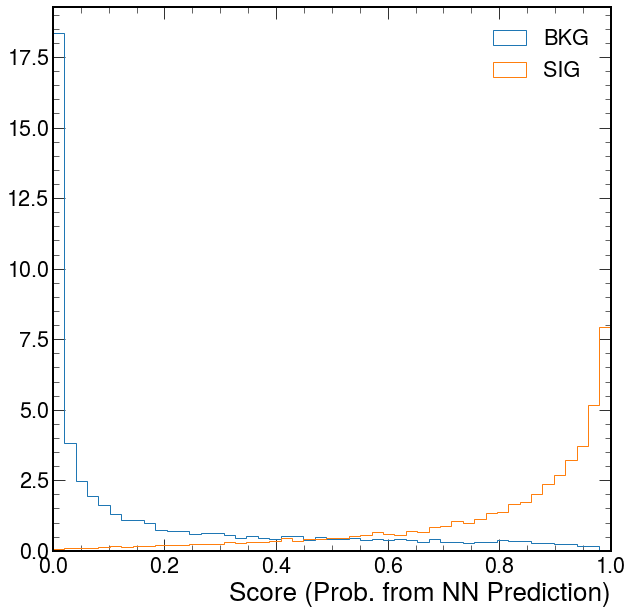

In [35]:
## 下面做出图像

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)

plt.hist(test_score[test_df['is_bkg']], label="BKG", histtype="step", bins=np.linspace(0,1), density=True)
plt.hist(test_score[test_df['is_sig']], label="SIG", histtype="step", bins=np.linspace(0,1), density=True)
plt.legend()
plt.xlabel("Score (Prob. from NN Prediction)")
plt.xlim(0,1)

## 训练一个简单的 Transformer 分类器

我们把上一节搭建起的 Transformer 的模块直接搬运过来，训练一个 Transformer 模型。

这里要考虑一个重要的问题：**我们的“token”是什么？原本是一维的（dim=26）的固定长度的输入，应该如何展成二维的数据？**

### 特殊的 Tokenization

很明显地，我们输入的26个特征可以归属为几个更高级别的object的特征：两个b-jet，两个轻子，和一个丢失横动量。尽管我们输入了两个b-jet各自的7个特征，但是我们人为把它们排了序，这本质上破坏了数据内禀的对于b-jet的特征交换不变的特点；对于两个轻子也是类似的。
因此，我们**不妨定义5个token**，分别对应这5个object。而且，对于两个b-jet，我们让他们的token embedding共享同一套变换网络；对两个轻子，也共享同一套网络，这就把数据内禀的层级结构嵌入到网络的设计中了。

除此以外，我们要定一个[CLS] token，因此放在了第1个位置。这就是我们为这个任务特别定制的 Embeddings 模块：

```python
class Embeddings(nn.Module):
    def __init__(self, config):
        super(Embeddings, self).__init__()
        self.token_embeddings = nn.ModuleList([
            nn.Linear(7, config.hidden_size), # embed bjet token
            nn.Linear(5, config.hidden_size), # embed lep token
            nn.Linear(2, config.hidden_size) # embed met token
        ])
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # add a trainable class token
        self.class_token = nn.Parameter(torch.randn(1, config.hidden_size))

    def forward(self, input):
        # input has size (batch_size, input_dim=26)
        embeddings = []
        embeddings.append(self.class_token.expand(input.size(0), -1)) # first token is the [CLS] token
        embeddings.append(self.token_embeddings[0](input[:, :7])) # bjet1 token embed by bjet embedding layer
        embeddings.append(self.token_embeddings[0](input[:, 7:14])) # bjet2 token embed by bjet embedding layer
        embeddings.append(self.token_embeddings[1](input[:, 14:19])) # lep1 token embed by lep embedding layer
        embeddings.append(self.token_embeddings[1](input[:, 19:24])) # lep2 token embed by lep embedding layer
        embeddings.append(self.token_embeddings[2](input[:, 24:])) # met token embed by met embedding layer
        embeddings = torch.stack(embeddings, dim=1)
        # now embeddings has dim (batch_size, num_tokens, hidden_size)
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings
```

对于其它模块，我们直接照搬上节的定义如下（请参照上一节的内容，再次理解一下各个模块的含义）。

In [18]:
def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / np.sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)

class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state))
        return attn_outputs

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        x = self.output_linear(x)
        return x

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)

    def forward(self, x):
        # Apply layer normalization and then copy input into query, key, value
        hidden_state = self.layer_norm_1(x)
        # Apply attention with a skip connection
        x = x + self.attention(hidden_state)
        # Apply feed-forward layer with a skip connection
        x = x + self.feed_forward(self.layer_norm_2(x))
        return x

###### Customized embedding layers ######
class Embeddings(nn.Module):
    def __init__(self, config):
        super(Embeddings, self).__init__()
        self.token_embeddings = nn.ModuleList([
            nn.Linear(7, config.hidden_size), # embed bjet token
            nn.Linear(5, config.hidden_size), # embed lep token
            nn.Linear(2, config.hidden_size) # embed met token
        ])
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # add a trainable class token
        self.class_token = nn.Parameter(torch.randn(1, config.hidden_size))

    def forward(self, input):
        # input has size (batch_size, input_dim=26)
        embeddings = []
        embeddings.append(self.class_token.expand(input.size(0), -1)) # first token is the [CLS] token
        embeddings.append(self.token_embeddings[0](input[:, :7])) # bjet1 token embed by bjet embedding layer
        embeddings.append(self.token_embeddings[0](input[:, 7:14])) # bjet2 token embed by bjet embedding layer
        embeddings.append(self.token_embeddings[1](input[:, 14:19])) # lep1 token embed by lep embedding layer
        embeddings.append(self.token_embeddings[1](input[:, 19:24])) # lep2 token embed by lep embedding layer
        embeddings.append(self.token_embeddings[2](input[:, 24:])) # met token embed by met embedding layer
        embeddings = torch.stack(embeddings, dim=1)
        # now embeddings has dim (batch_size, num_tokens, hidden_size)
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

########################################

class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList([TransformerEncoderLayer(config)
                                     for _ in range(config.num_hidden_layers)])

    def forward(self, x):
        x = self.embeddings(x)
        for layer in self.layers:
            x = layer(x)
        return x

class TransformerForSequenceClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = TransformerEncoder(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, x):
        x = self.encoder(x)[:, 0, :] # select hidden state of [CLS] token
        x = self.dropout(x)
        x = self.classifier(x)
        return x

接下来定义 pytorch-lightning model

In [19]:
from types import SimpleNamespace
config = SimpleNamespace(
    hidden_size = 16,  # Hidden size for embeddings and Transformer
    num_attention_heads = 4,  # Number of attention heads
    intermediate_size = 32,  # Feed forward intermediate size
    num_hidden_layers = 2,  # Number of Transformer layers
    hidden_dropout_prob = 0.1,  # Dropout probability
    num_labels = 2  # Number of output classes
)

# Define the PyTorch Lightning model
class SimpleTransformer(pl.LightningModule):
    def __init__(self, config):
        super(SimpleTransformer, self).__init__()
        self.mod = TransformerForSequenceClassification(config)

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=config.num_labels) # 帮助我们计算准确率的
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=config.num_labels)

    def forward(self, x):
        return self.mod(x)

    def training_step(self, batch, batch_idx):
        # 这里是pytorch-lightning的扩展功能，定义每个training step (训练每个batch的时候）之后做什么事情
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.train_acc(logits, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # 这里是pytorch-lightning的扩展功能，定义每个validaiton step (在当前epoch训练结束后，开始validation的每个batch）之后做什么事情
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.val_acc(logits, y)
        self.log('val_loss', loss)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        # 选用什么优化器
        return torch.optim.Adam(self.parameters(), lr=0.001)

# 定义model的实例
model_transformer = SimpleTransformer(config)

# 打印下这个模型进行检查
print(model_transformer)


SimpleTransformer(
  (mod): TransformerForSequenceClassification(
    (encoder): TransformerEncoder(
      (embeddings): Embeddings(
        (token_embeddings): ModuleList(
          (0): Linear(in_features=7, out_features=16, bias=True)
          (1): Linear(in_features=5, out_features=16, bias=True)
          (2): Linear(in_features=2, out_features=16, bias=True)
        )
        (layer_norm): LayerNorm((16,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (layer_norm_1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (layer_norm_2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (attention): MultiHeadAttention(
            (heads): ModuleList(
              (0-3): 4 x AttentionHead(
                (q): Linear(in_features=16, out_features=4, bias=True)
                (k): Linear(in_features=16, out_features=4, bias=True)
  

In [20]:
# Trainer with a logger
trainer = pl.Trainer(max_epochs=50, logger=pl.loggers.TensorBoardLogger('tb_logs'))

# Fit the model
trainer.fit(model_transformer, train_loader, val_loader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type                                 | Params
-------------------------------------------------------------------
0 | mod       | TransformerForSequenceClassification | 4.8 K 
1 | train_acc | MulticlassAccuracy                   | 0     
2 | val_acc   | MulticlassAccuracy                   | 0     
-------------------------------------------------------------------
4.8 K     Trainable params
0         Non-trainable params
4.8 K     Total params
0.019     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/olympus/licq/utils/miniconda3/envs/weaver/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.
/home/olympus/licq/utils/miniconda3/envs/weaver/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


### 思考：

1. `token_embeddings` 为什么是三个？分别是什么？为什么`in_features`不一样，而`out_features`必须一样？
```
(token_embeddings): ModuleList(
  (0): Linear(in_features=7, out_features=20, bias=True)
  (1): Linear(in_features=5, out_features=20, bias=True)
  (2): Linear(in_features=2, out_features=20, bias=True)
)
```
2. 这里定义的`q`, `k`, `v` 三个线性层，为什么`output_features`变成了5？
```
(heads): ModuleList(
  (0-3): 4 x AttentionHead(
    (q): Linear(in_features=20, out_features=5, bias=True)
    (k): Linear(in_features=20, out_features=5, bias=True)
    (v): Linear(in_features=20, out_features=5, bias=True)
  )
```

下面我们依然在测试集上检查最终输出score的分布图：

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/olympus/licq/utils/miniconda3/envs/weaver/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=71` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

(0.0, 1.0)

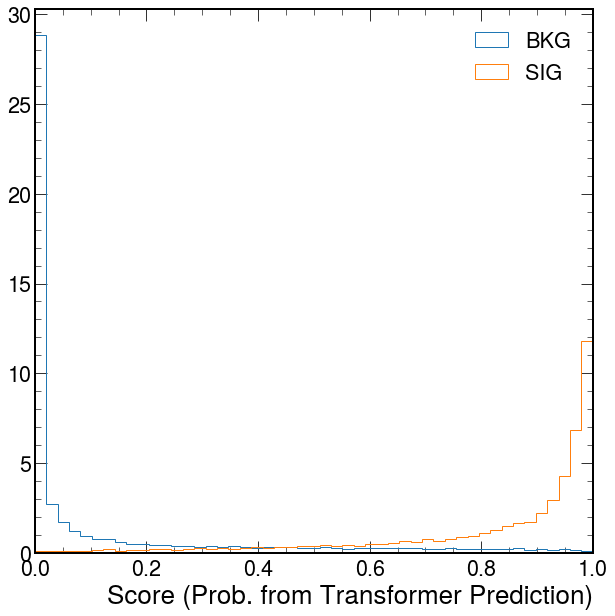

In [23]:
# Use the trainer to predict
predictions_transformer = trainer.predict(model_transformer, dataloaders=test_loader)
predictions_transformer = [p.numpy() for batch in predictions_transformer for p in batch]

test_score = np.array([np.exp(p[1]) / (np.exp(p[0]) + np.exp(p[1])) for p in predictions_transformer]) # 注意，我们取第二个神经元，因为它是signal对应的神经元

## 下面做出图像

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)

plt.hist(test_score[test_df['is_bkg']], label="BKG", histtype="step", bins=np.linspace(0,1), density=True)
plt.hist(test_score[test_df['is_sig']], label="SIG", histtype="step", bins=np.linspace(0,1), density=True)
plt.legend()
plt.xlabel("Score (Prob. from Transformer Prediction)")
plt.xlim(0,1)

## 用 Tensorboard 监控输出

Tensorboard 是非常方便的检查训练、检测指标的监控软件，如果用过Jupyter，它的用法和Jupyter非常相似：打开一个Tensorboard服务，然后在浏览器访问特定的端口，就可以使用服务了。

在notebook中可以用如下的魔术命令打开Tensorboard：

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir tb_logs

## 如果在 Google Colab 上，这可以直接成功。

## 如果在lxslc上运行，则还需要把 TensorBoard 服务的端口绑定到本地端口，就像开启 Jupyter 服务时那样。
## 例如，如报错信息，显示 Reusing TensorBoard on port 6006，则把 6006 端口绑定到本地 6006 端口
## 新开一个本地的shell，然后执行: ssh -L 6006:localhost:6006 <相应lxslc节点>

可以看到 MLP 和 Transformer 的训练准确率（Accuracy）和损失函数（Loss）的曲线分别是这样的。我们的 Transformer 表现更好，获得胜利！

<img src="figures/tensorboard_output.png" alt="image" width=900/>